Empirical question
4. a).

In [1]:
import scipy.interpolate
import pandas as pd
from pandas import *
import scipy.optimize as optimize
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np
from numpy import linalg as LA

In [2]:
# read the data file.
xls = pd.ExcelFile('/Users/apple/Desktop/data for APM466 AS1.xlsx')
df1 = pd.read_excel(xls, '1.2')
df2 = pd.read_excel(xls, '1.3')
df3 = pd.read_excel(xls, '1.6')
df4 = pd.read_excel(xls, '1.7')
df5 = pd.read_excel(xls, '1.8')
df6 = pd.read_excel(xls, '1.9')
df7 = pd.read_excel(xls, '1.10')
df8 = pd.read_excel(xls, '1.13')
df9 = pd.read_excel(xls, '1.14')
df10 = pd.read_excel(xls, '1.15')
df = [df1,df2,df3,df4,df5,df6,df7,df8,df9,df10]

In [3]:
# calculation of half year time to maturity.
def ttm(x):
    current_date = list(x.columns.values)[0]
    x['time to maturity'] = [(maturity - current_date).days for maturity in x['maturity date']]

In [4]:
# calculation of yield to maturity.
def ytm(x):
    tr, yr = [], []
    for i, bond in x.iterrows():
        ttm = bond['time to maturity']
        tr.append(ttm/365)
        
        # separate the time to maturity to small time interval.
        y = int(ttm/182)
        init = (ttm%182)/365
        time = np.asarray([2 * init + n for n in range(0,y+1)])

        # convert the clean close price to dirty price.
        coupon = bond['coupon'] * 100/2
        accrued_interest = coupon * ((182- ttm%182)/365)
        dirty_price = bond['close price'] + accrued_interest
        
        # make each payments in different time period as an array.
        pmt = np.asarray([coupon] * y + [coupon + 100])
        
        # use optimization to solve the yield to maturity.
        ytm_func = lambda y: np.dot(pmt, (1+y/2) ** (-time)) - dirty_price
        ytm = optimize.fsolve(ytm_func, .05)
        yr.append(ytm)
    return tr,yr

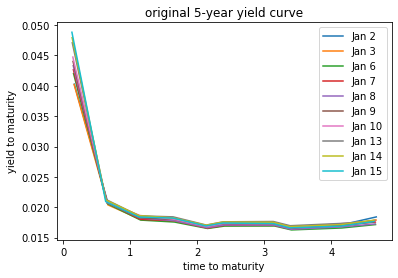

In [5]:
# plot the yield curve:
labels = ['Jan 2','Jan 3','Jan 6','Jan 7','Jan 8',
         'Jan 9','Jan 10','Jan 13','Jan 14','Jan 15']
plt.xlabel('time to maturity')
plt.ylabel('yield to maturity')
plt.title('original 5-year yield curve')
i = 0
for d in df:
    ttm(d)
    plt.plot(ytm(d)[0], ytm(d)[1], label = labels[i])
    i = i+1
plt.legend()

In [6]:
# interpolation.
def ip(tr, yr):
    t = [0.5,1,1.5,2,2.5,3,3.5,4,4.5]
    y = []
    interp = scipy.interpolate.interp1d(tr, yr, bounds_error=False)
    for i in t:
        value = float(interp(i))
        if not scipy.isnan(value):
            y.append(value)
    return t,y

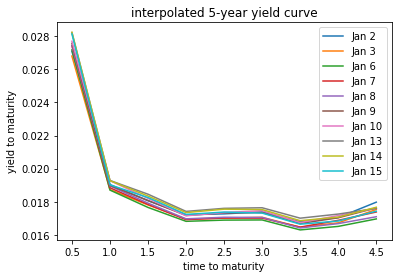

In [7]:
# plot the interpolated yield curve:
labels = ['Jan 2','Jan 3','Jan 6','Jan 7','Jan 8',
         'Jan 9','Jan 10','Jan 13','Jan 14','Jan 15']
plt.xlabel('time to maturity')
plt.ylabel('yield to maturity')
plt.title('interpolated 5-year yield curve')
i = 0
for d in df:
    ttm(d)
    result = ytm(d)
    a = np.asarray(result[0])
    b = np.asarray(result[1]).squeeze()
    y = ip(a,b)
    plt.plot(y[0], y[1], label = labels[i])
    i = i+1
plt.legend()

b).

In [8]:
# bootstrapping and calculate the spot rate:
def spot(x):
    s = np.empty([1,10])
    tr = []
    coupons = []
    dirty_price = []
    for i, bond in x.iterrows():
        ttm = bond['time to maturity']
        tr.append(ttm/365)
        coupon = float(bond['coupon']) * 100/2
        coupons.append(coupon)
        accrued_interest = coupon * (0.5 - (ttm % 182)/365)
        dirty_price.append(bond['close price'] + accrued_interest)
        
    for i in range(0,10):
        if i == 0:
            # 0 <= T <= 0.5:
            s[0, i] = -np.log(dirty_price[i]/(coupons[i]+100))/tr[i]
        else:
            # 0.5 <= T <= 1:
            pmt = np.asarray([coupons[i]] * i + [coupons[i] + 100])
            spot_func = lambda y: np.dot(pmt[:-1], 
                        np.exp(-(np.multiply(s[0,:i], tr[:i])))) + pmt[i] * np.exp(-y * tr[i]) - dirty_price[i]      
            s[0, i] = optimize.fsolve(spot_func, .05)        
    return tr, s            

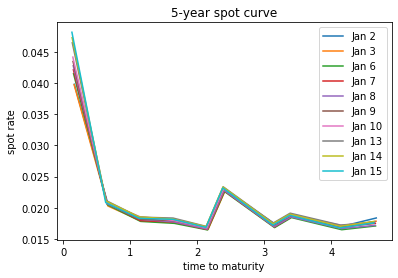

In [9]:
# plot the spot curve:
labels = ['Jan 2','Jan 3','Jan 6','Jan 7','Jan 8',
         'Jan 9','Jan 10','Jan 13','Jan 14','Jan 15']
plt.xlabel('time to maturity')
plt.ylabel('spot rate')
plt.title('5-year spot curve')
i = 0
for d in df:
    ttm(d)
    plt.plot(spot(d)[0], spot(d)[1].squeeze(), label = labels[i])
    i = i+1
plt.legend()

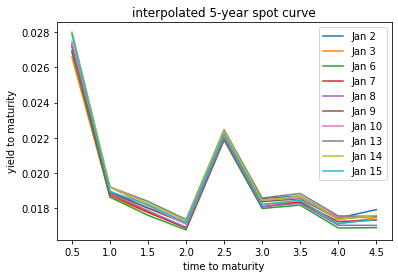

In [10]:
# spot rate after interpolation:
labels = ['Jan 2','Jan 3','Jan 6','Jan 7','Jan 8',
         'Jan 9','Jan 10','Jan 13','Jan 14','Jan 15']
plt.xlabel('time to maturity')
plt.ylabel('yield to maturity')
plt.title('interpolated 5-year spot curve')
i = 0
for d in df:
    ttm(d)
    result = spot(d)
    a = np.asarray(result[0])
    b = np.asarray(result[1]).squeeze()
    y = ip(a,b)
    plt.plot(y[0], y[1], label = labels[i])
    i = i+1
plt.legend()

c).

In [11]:
# the forward curve:
def forward(x):
    s = spot(x)[1].squeeze()
    f1 = (s[3] * 2 - s[1] * 1)/(2-1)
    f2 = (s[5] * 3 - s[1] * 1)/(3-1)
    f3 = (s[7] * 4 - s[1] * 1)/(4-1)
    f4 = (s[9] * 5 - s[1] * 1)/(5-1)
    f = [f1,f2,f3,f4]
    return f

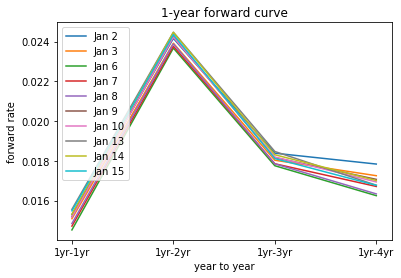

In [12]:
# plot the forward curve:
labels = ['Jan 2','Jan 3','Jan 6','Jan 7','Jan 8',
         'Jan 9','Jan 10','Jan 13','Jan 14','Jan 15']
plt.xlabel('year to year')
plt.ylabel('forward rate')
plt.title('1-year forward curve')
i = 0
for d in df:
    ttm(d)
    plt.plot(['1yr-1yr','1yr-2yr','1yr-3yr','1yr-4yr'], forward(d), label = labels[i])
    i = i+1
plt.legend()

5.

In [13]:
# the calculation of log returns matrix of yield.
log = np.empty([5,9])
y = np.empty([5,10])
for i in range(len(df)):
    ttm(df[i])
    y[0,i] = ytm(df[i])[1][1]
    y[1,i] = ytm(df[i])[1][3]
    y[2,i] = ytm(df[i])[1][5]
    y[3,i] = ytm(df[i])[1][7]
    y[4,i] = ytm(df[i])[1][9]
    
for i in range(0, 9):
    log[0, i] = np.log(y[0,i+1]/y[0,i])
    log[1, i] = np.log(y[1,i+1]/y[1,i])
    log[2, i] = np.log(y[2,i+1]/y[2,i])
    log[3, i] = np.log(y[3,i+1]/y[3,i])
    log[4, i] = np.log(y[4,i+1]/y[4,i])
    
# calculation of the covariance matrix.
np.cov(log)        

array([[1.07090954e-04, 7.92780446e-05, 7.58693524e-05, 9.93497720e-05,
        5.85320913e-05],
       [7.92780446e-05, 1.32011547e-04, 1.08733808e-04, 1.38898015e-04,
        1.73585782e-04],
       [7.58693524e-05, 1.08733808e-04, 1.07620798e-04, 1.30767308e-04,
        1.79317943e-04],
       [9.93497720e-05, 1.38898015e-04, 1.30767308e-04, 1.64234999e-04,
        2.10784390e-04],
       [5.85320913e-05, 1.73585782e-04, 1.79317943e-04, 2.10784390e-04,
        5.92227349e-04]])

In [14]:
# the calculation of covariance matrix of the forward yield.
f = np.empty([4,10])
for i in range(len(df)):
    f[0,i] = forward(df[i])[0]
    f[1,i] = forward(df[i])[1]
    f[2,i] = forward(df[i])[2]
    f[3,i] = forward(df[i])[3]

# calculation of the covariance matrix.
np.cov(f)

array([[1.10937237e-07, 8.98697200e-08, 7.16100589e-08, 7.86230703e-08],
       [8.98697200e-08, 8.31463410e-08, 6.10497337e-08, 4.97684748e-08],
       [7.16100589e-08, 6.10497337e-08, 5.78087258e-08, 7.17557876e-08],
       [7.86230703e-08, 4.97684748e-08, 7.17557876e-08, 2.06686648e-07]])

6.

In [15]:
# eigenvalues and eigenvectors of covariance matrix of log returns of yield:
w, v = LA.eig(np.cov(log))
w

array([8.57575340e-04, 2.05773760e-04, 2.93517020e-05, 9.11689963e-06,
       1.36794498e-06])

In [16]:
v

array([[-1.79200804e-01, -5.47144684e-01,  7.66994103e-01,
        -2.71924667e-01,  7.93522959e-02],
       [-3.28264420e-01, -3.56887372e-01, -5.74741877e-01,
        -6.32712578e-01,  1.84987684e-01],
       [-3.19749854e-01, -2.74083133e-01, -1.18356868e-01,
         6.18775585e-01,  6.52492830e-01],
       [-3.88582304e-01, -3.94270061e-01, -1.67822047e-01,
         3.62842877e-01, -7.30572187e-01],
       [-7.79033610e-01,  5.85400422e-01,  1.98038462e-01,
        -1.05799771e-01,  3.95446607e-04]])

In [17]:
# eigenvalues and eigenvectors of covariance matrix of forward rates:
a, b = LA.eig(np.cov(f))
a

array([3.38697898e-07, 1.09469110e-07, 6.89182777e-09, 3.52011631e-09])

In [18]:
b

array([[ 0.50635449,  0.43407024,  0.67068765, -0.32460166],
       [ 0.39865052,  0.49640086, -0.27323666,  0.72111419],
       [ 0.38456825,  0.17170751, -0.68768248, -0.59136842],
       [ 0.66090102, -0.73190556,  0.05111368,  0.15783373]])